### We saw that the cosine similarity distribution of the words was centered around 0.35 where relatively most of the words had same cosine similarity from Average vector representation, which means, the words can be some what generalized to a concept in this case.... 

In [1]:
from gensim.models import Word2Vec
import pickle 
import marshal
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics
import time
import hashlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
if(0):    
    model = Word2Vec.load('./Word2Vec_models/Word2Vec_version1')
    marshal_in = open("./marshal_files/cluster_1_words.marshal","rb")
    cluster_1 = marshal.load(marshal_in)

In [4]:
cluster_1_vec = [model.wv[word] for word in cluster_1]
X = np.asarray(cluster_1_vec)

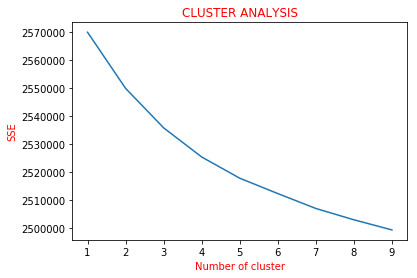

In [15]:
if(0):
    sse_10 = {}
    
    for k in range(1, 10):
        kmeans = cluster.KMeans(n_clusters=k, max_iter=300 , n_jobs = -1).fit(X)
        labels = kmeans.labels_
        sse_10[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse_10.keys()), list(sse_10.values()))
    plt.xlabel("Number of cluster", color ='red')
    plt.ylabel("SSE" , color ='red')
    plt.title('CLUSTER ANALYSIS' , color ='red')
    plt.show()

we dont see a clear elbow in the plot here therefore elbow method is not appropriate to use. Let's use more heuristic approach,GAP statistics, to get optimal number of clusters

#### Use GAP statistics to find the optimal number of clusters 

In [54]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [55]:
import time
start = time.time()
k, gapdf = optimalK(X, nrefs=3, maxClusters=15)
print ('Optimal k is: ', k)
print('Total time to find clusters :',time.time()-start)

Optimal k is:  13
Total time to find clusters : 11874.694040298462


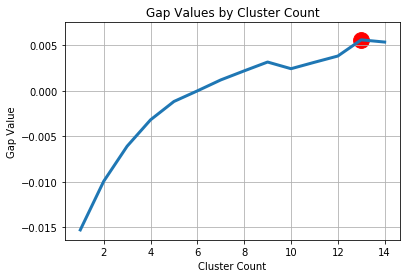

In [56]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


Now use the number of clusters to get the optimal clusters to cluster our dataset...... 

In [7]:
if(0):    
    kmeans = cluster.KMeans(n_clusters=14, max_iter=300 , n_jobs = -1).fit(X)
    labels = kmeans.labels_


In [5]:
k = 14 # number of clusters

After Clustering create list of words for each of the cluster.....

In [8]:
#first create dictionary of each word with cluster number attached to it 
# creating list with list where each list has words for that cluster 

list_word_label_dict= dict(zip(cluster_1,labels))
list_cluster_words = []
for i in range(14):
    cluster_words = []
    for word , label in list_word_label_dict.items():
        if(label == i ):
            cluster_words.append(word)
    list_cluster_words.append(cluster_words)                

Let's see the number of words in each of the cluster and remove any irrelevant clusters...



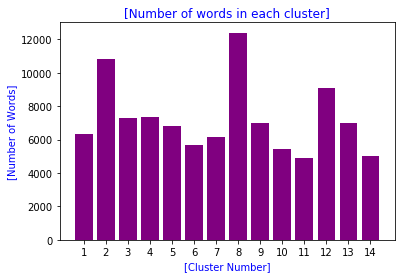

Number of Words Cluster  0  :  6314
Number of Words Cluster  1  :  10831
Number of Words Cluster  2  :  7269
Number of Words Cluster  3  :  7324
Number of Words Cluster  4  :  6811
Number of Words Cluster  5  :  5698
Number of Words Cluster  6  :  6161
Number of Words Cluster  7  :  12400
Number of Words Cluster  8  :  7015
Number of Words Cluster  9  :  5419
Number of Words Cluster  10  :  4900
Number of Words Cluster  11  :  9085
Number of Words Cluster  12  :  7002
Number of Words Cluster  13  :  5001


In [9]:
# plot bar graph showing number of words in each cluster ... 

x = np.arange(1,k+1,1)
y = [len(list_cluster_words[i]) for i in range(k)]
plt.bar(x,y,color = 'purple')
plt.xlabel('[Cluster Number]',color = 'blue')
plt.ylabel('[Number of Words]',color = 'blue')
plt.title('[Number of words in each cluster]',color = 'blue')
plt.xticks(np.arange(1, k+1, step=1))
plt.show()
for i in range(len(list_cluster_words)):
    print('Number of Words Cluster ',str(i),' : ',len(list_cluster_words[i]))

Nothing of that relevance .. let's remove the clusters 

In [10]:
# store the cluster in file as marshal object 
cluster_dir ='./marshal_files'
marshal_in = open(cluster_dir+'cluster_0_0'+'_words.marshal','wb')
marshal.dump(list_cluster_words,marshal_in)
marshal_in.close()

We will look at an average how similar are the projections of these words within the cluster ...

In [11]:
def cosine_function(x,y):
    c = np.dot(x,y)
    norm_a = np.linalg.norm(x)
    norm_b = np.linalg.norm(y)
    cosine_val = c/((norm_a)*(norm_b))
    return(cosine_val)

In [12]:
# list with list of pair-wise
list_cosine_each_word_clusters = []
list_average_cosine_clusters = []

    
for i in range(k):
    list_cosine_word = []
    loop = len(list_cluster_words[i])-1
    for index in range(len(list_cluster_words[i])):
        for j in range(loop):
            if(loop == 0):
                break
            list_cosine_word.append(cosine_function(model.wv[list_cluster_words[i][j]],model.wv[list_cluster_words[i][j+1]]))
            loop = loop -1 
    list_cosine_each_word_clusters.append(list_cosine_word)
    list_average_cosine_clusters.append(np.mean(list_cosine_word))

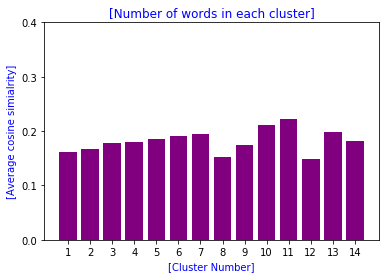

In [13]:

x = np.arange(1,k+1,1)
y = list_average_cosine_clusters
plt.bar(x,y,color = 'purple')
plt.xlabel('[Cluster Number]',color = 'blue')
plt.ylabel('[Average cosine simialrity]',color = 'blue')
plt.title('[Number of words in each cluster]',color = 'blue')
plt.xticks(np.arange(1,k+1, step=1))
plt.yticks(np.arange(0,0.5, step=0.1))
plt.show()

Now let's find the average word vector for each of the cluster... 

In [14]:
# list_avg_word_vector is a list of vectors where each vector represents 
list_avg_word_vector = []
for i in range(k):
    word_vector= 0
    for word, label in list_word_label_dict.items():
        if(label == i):
            word_vector = np.add(word_vector,np.asarray(model.wv[word]))
    list_avg_word_vector.append(word_vector/len(list_cluster_words[i]))


            
    

In [15]:
len(list_avg_word_vector)

14

Now let's find cosine similarity of each of the word w.r.t to the average word vector .... 

In [16]:
list_cosine_sim_avg_clusters = []
for i in range(k):
    list_cosine_sim_avg_clusters.append([cosine_function(list_avg_word_vector[i],model.wv[word]) for word in list_cluster_words[i]])


            

Define a function which gives the summary statistics of cosine distribution of the each cluster w.r.t to the average vector representation

In [17]:
def cluster_summary(cosine_similarity,cluster_number):
    print('Summary Statistics of Cosine Similairty Distribution CLUSTER '+ str(cluster_number+1) +' --------->')
    print()
    print('Average Cosine similarity :', np.mean(cosine_similarity))
    print('Max Cosine Similarity :', max(cosine_similarity))
    print('Min Cosine Similarity :',min(cosine_similarity))
    print('Standard Deviation of the Cosine similarity Distribution :',np.std(cosine_similarity))

    x = np.arange(0,max(cosine_similarity), 0.02)
    y = cosine_similarity
    plt.hist(y,bins =x,histtype = 'barstacked',color = 'green')
    plt.xlabel('[Cosine Values]',color = 'blue')
    plt.ylabel('[Number of Words]',color = 'blue')
    plt.title('[Cosine Distribution for Cluster '+str(cluster_number+1)+']',color = 'blue')
    plt.show()

Let's plot the cosine sim distribution plot for each cluster and try to see whether these cluster can be 

generalised or to what extent it can be generalized

Summary Statistics of Cosine Similairty Distribution CLUSTER 1 --------->

Average Cosine similarity : 0.31075928
Max Cosine Similarity : 0.5220472
Min Cosine Similarity : 0.1688474
Standard Deviation of the Cosine similarity Distribution : 0.050377004


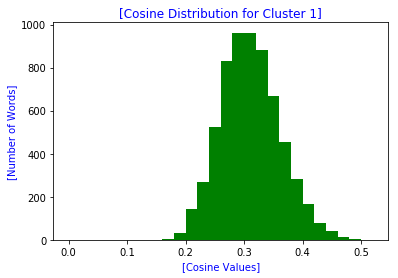

In [19]:
cluster_summary(list_cosine_sim_avg_clusters[0],0)


Summary Statistics of Cosine Similairty Distribution CLUSTER 2 --------->

Average Cosine similarity : 0.30614838
Max Cosine Similarity : 0.5278272
Min Cosine Similarity : 0.11448297
Standard Deviation of the Cosine similarity Distribution : 0.05217542


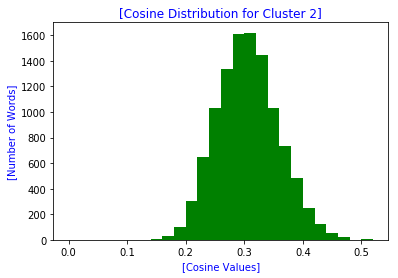

In [20]:
cluster_summary(list_cosine_sim_avg_clusters[1],1)

Summary Statistics of Cosine Similairty Distribution CLUSTER 3 --------->

Average Cosine similarity : 0.32015827
Max Cosine Similarity : 0.5318421
Min Cosine Similarity : 0.18066908
Standard Deviation of the Cosine similarity Distribution : 0.047679022


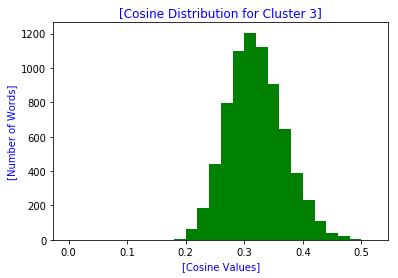

In [21]:
cluster_summary(list_cosine_sim_avg_clusters[2],2)

Summary Statistics of Cosine Similairty Distribution CLUSTER 4 --------->

Average Cosine similarity : 0.33683917
Max Cosine Similarity : 0.5866477
Min Cosine Similarity : 0.18003489
Standard Deviation of the Cosine similarity Distribution : 0.052212443


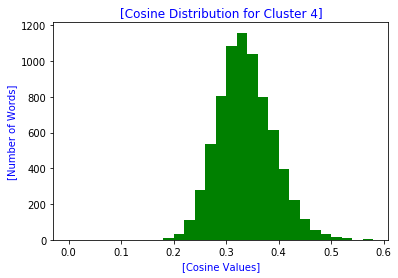

In [22]:
cluster_summary(list_cosine_sim_avg_clusters[3],3)

Summary Statistics of Cosine Similairty Distribution CLUSTER 6 --------->

Average Cosine similarity : 0.33431357
Max Cosine Similarity : 0.5447075
Min Cosine Similarity : 0.18051898
Standard Deviation of the Cosine similarity Distribution : 0.054747377


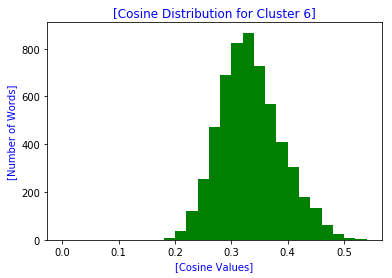

In [23]:
cluster_summary(list_cosine_sim_avg_clusters[5],5)

Summary Statistics of Cosine Similairty Distribution CLUSTER 7 --------->

Average Cosine similarity : 0.33715367
Max Cosine Similarity : 0.5315095
Min Cosine Similarity : 0.18637459
Standard Deviation of the Cosine similarity Distribution : 0.052562226


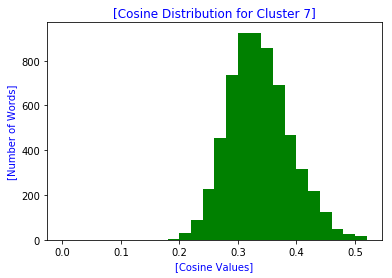

In [24]:
cluster_summary(list_cosine_sim_avg_clusters[6],6)

Summary Statistics of Cosine Similairty Distribution CLUSTER 8 --------->

Average Cosine similarity : 0.2815721
Max Cosine Similarity : 0.52422047
Min Cosine Similarity : 0.12230042
Standard Deviation of the Cosine similarity Distribution : 0.053554755


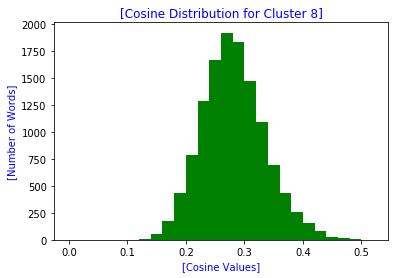

In [25]:
cluster_summary(list_cosine_sim_avg_clusters[7],7)

Summary Statistics of Cosine Similairty Distribution CLUSTER 9 --------->

Average Cosine similarity : 0.31941745
Max Cosine Similarity : 0.5020427
Min Cosine Similarity : 0.1854222
Standard Deviation of the Cosine similarity Distribution : 0.04432449


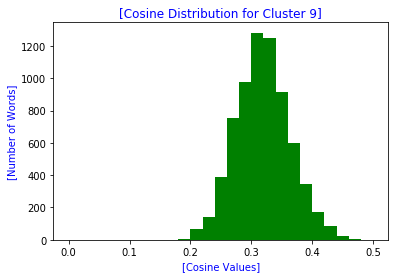

In [26]:
cluster_summary(list_cosine_sim_avg_clusters[8],8)

Summary Statistics of Cosine Similairty Distribution CLUSTER 10 --------->

Average Cosine similarity : 0.36530012
Max Cosine Similarity : 0.64847267
Min Cosine Similarity : 0.20360807
Standard Deviation of the Cosine similarity Distribution : 0.057343006


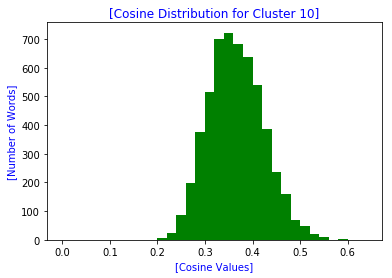

In [27]:
cluster_summary(list_cosine_sim_avg_clusters[9],9)

Summary Statistics of Cosine Similairty Distribution CLUSTER 11 --------->

Average Cosine similarity : 0.37294066
Max Cosine Similarity : 0.63525116
Min Cosine Similarity : 0.20447214
Standard Deviation of the Cosine similarity Distribution : 0.06329404


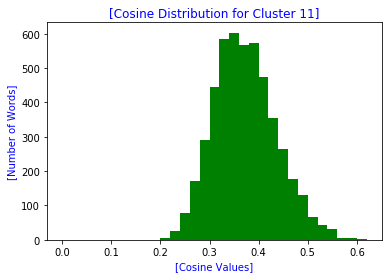

In [28]:
cluster_summary(list_cosine_sim_avg_clusters[10],10)

Summary Statistics of Cosine Similairty Distribution CLUSTER 12 --------->

Average Cosine similarity : 0.303125
Max Cosine Similarity : 0.48503962
Min Cosine Similarity : 0.16215563
Standard Deviation of the Cosine similarity Distribution : 0.045952532


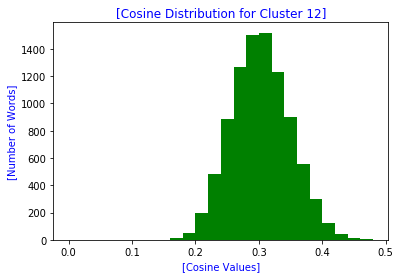

In [29]:
cluster_summary(list_cosine_sim_avg_clusters[11],11)

In [34]:
list_threshold_clusters = []

for i in range(k):
    list_threshold_clusters.append(np.percentile(list_cosine_sim_avg_clusters[i],95))
    

In [35]:
# Let's have concepts candidates out of the clusters ! 

def candidate_concepts(label_list,cosine_similarity,threshold_cosine):
    concept_list= []
    for x in range(len(cosine_similarity)):
        if(cosine_similarity[x]>threshold_cosine):
            concept_list.append(label_list[x])
    return(concept_list)

In [36]:
# List of list of words for each cluster as candidate concepts 
list_candidate_concept_words = []
for i in range(k):
    list_candidate_concept_words.append(candidate_concepts(list_cluster_words[i],list_cosine_sim_avg_clusters[i],list_threshold_clusters[i]))
for i in range(k):    
    print('Number of Candidate words for Cluster ',str(i+1),' : ',len(list_candidate_concept_words[i]))    

Number of Candidate words for Cluster  1  :  316
Number of Candidate words for Cluster  2  :  542
Number of Candidate words for Cluster  3  :  364
Number of Candidate words for Cluster  4  :  367
Number of Candidate words for Cluster  5  :  341
Number of Candidate words for Cluster  6  :  285
Number of Candidate words for Cluster  7  :  308
Number of Candidate words for Cluster  8  :  620
Number of Candidate words for Cluster  9  :  351
Number of Candidate words for Cluster  10  :  271
Number of Candidate words for Cluster  11  :  245
Number of Candidate words for Cluster  12  :  455
Number of Candidate words for Cluster  13  :  351
Number of Candidate words for Cluster  14  :  250


In [37]:
print(list_candidate_concept_words[0])

['airport', 'shuttle', 'pickup', 'flight', 'straightforward', 'fares', 'ontime', 'affordablethey', 'aiport', 'Limo', 'Luggage', 'layover', 'minuten', 'minibus', 'quietet', 'arrivaldeparture', 'httpwwwentertainmentplusnet', 'usone', 'nachosfantastic', 'pizzajust', 'httpentertainmentplusnettourtptpdccfm', 'JFK', 'shich', 'vansbuses', 'KHRreservations', 'throughlive', '50p', 'rounders', 'thefees', 'transportationThey', 'Ciampino', 'Trenitaly', 'taximetro', 'Changhi', 'hotelairport', 'AUD65', 'pmso', 'driveroptional', 'andcoffee', 'Pearson', 'googleing', 'onesome', 'attractionsit', 'aikrporthotel', 'meterLocation', '100drh', '35AED', 'turisk', 'placewed', 'Chancellorwill', 'gadgee', 'Thrify', '3500usd', 'Interline', 'youwhich', 'intructions', 'STAYBRIDGE', '615A', 'Seattlealthough', 'airportmall', 'Dhs55', 'conjuncting', 'waterparkAll', 'altougfh', 'carwhen', 'MacCarran', 'canceledSpoke', 'gustinianna', 'Eurosroom', 'Suburan', 'S23', 'similarlpriced', 'phonedata', 'costfree', 'beneifts', '

In [38]:
print(list_candidate_concept_words[1])

['cosy', 'Chose', 'faulted', 'Spotlessly', 'redecorated', 'Conference', 'spacey', 'lastminute', 'heatwave', 'september', 'homely', 'Accommodation', 'faultless', 'Aircon', 'december', 'travelodge', 'Bedrooms', 'feb', 'fantastically', 'comfotable', 'characterful', 'pricequality', 'august', 'kitted', 'london', 'favourably', 'classed', 'Excelent', 'jan', 'atending', 'spaceous', 'Sydney', 'citytrip', 'qualitycost', 'Â£97', 'spacy', 'Bloomsbury', 'travelodges', 'seeingtheatre', 'promis', 'choosed', 'epuiped', 'ecxelent', 'amstelveen', 'minibareverything', 'roomClean', 'tramsystem', 'accomodationfully', 'Mercure', 'friendlyrooms', 'breakfastterrace', 'Safebox', 'centralish', 'qualityprice', '4042inch', 'Icycold', 'stalltoiletwashbasin', 'acceptableContinental', 'consigliato', 'comfyHad', 'accommodationsamenities', 'accces', 'covnerted', 'greay', 'Onnie', 'philosphy', 'tidydo', 'freeavailable', 'lecated', 'opposote', 'helpfulcheck', '4Value', 'c£200', 'Najd', 'Messe', 'unspectacupar', 'doIts',

In [39]:
print(list_candidate_concept_words[2])

['Stayed', 'nights', 'stayed', 'April', 'July', 'reserved', 'upgraded', 'booked', 'suite', 'upgrade', 'Booked', 'September', 'Suite', 'March', 'suites', 'Jan', 'October', 'twobed', '11261129t', 'January', 'QueenQueen', 'Suites', 'Deluxe', 'kingsize', 'deluxe', 'Expedia', 'executive', 'Dec', '16th', 'citymarket', 'cityview', '32nd', 'parital', 'PreCruise', 'Upgraded', 'CDN129', '2529th', 'pacificplazahotelcom', 'CheckinThe', '105night', '95nt', 'Sept2425', 'befroe', 'ownbid', 'travelzoo', 'AgentJudy', 'McCrackenGreat', 'Febearly', 'Poblocki', '1bdrm', 'portCoronado', 'mountainviewgolf', 'roomscar', 'groundspoolbeach', '29May', 'Holo', 'bdrm', '244AUD', 'floorcorner', 'br', '67a', '6B', 'reuinion', 'hotelsuite', 'Ebreaks', 'GOt', 'possibele', 'sofabedrefrigerator', 'US430incl', '4900night', 'Euros4', 'Bennicassim', 'AmazzInn', '60tax', 'Au1000', 'Campaign', 'rollawaybeds', '11thSeptember', 'birthdaybooking', 'zoo109We', '99nite', 'Fairmontcom', '1216â‚¬', 'purchasewhat', 'insteadour', 'a

In [40]:
print(list_candidate_concept_words[3])

['decor', 'decorated', 'modern', 'furnishings', 'hip', 'trendy', 'chic', 'dated', 'quirky', 'boutique', 'design', 'style', 'Decor', 'designed', 'deco', 'classic', 'retro', 'pattens', 'gaudy', 'decoration', 'stylish', 'oldworld', 'lavishly', 'furnishing', 'understated', 'intimacy', 'opulence', 'finishings', 'interiors', 'edgy', 'stylishly', 'fittings', 'opulent', 'modernist', 'minimalist', 'functionality', 'reflected', 'oldstyle', 'retains', 'fabrics', 'modernised', 'mnore', 'ceilinged', 'furnitures', 'miscut', 'styling', '1990s', 'spruced', 'glamour', 'Scandinavian', 'subdued', 'Trendy', 'blanketing', 'Wach', 'lookingworn', 'slipcovers', 'kitsch', 'Catalog', 'stuckintheearly90s', 'panelled', 'Mid6070s', 'luxuriously', 'whimsy', 'garish', 'nonethen', 'schemes', 'cuttingedge', 'characterless', 'Decoration', 'designhotel', 'bygone', 'tapestry', 'baroque', 'townhomelarge', 'Weststyle', 'artdeco', 'roomcheap', 'redesigned', 'minimalism', 'Starck', 'avantgarde', 'Unnassuming', 'reons', 'wuv'

In [41]:
print(list_candidate_concept_words[4])

['Hilton', 'Inns', 'Fairmont', 'properties', 'Westin', 'Marriott', 'motels', 'Doubletree', 'fourstar', 'Marriot', 'worldwide', 'Carlton', 'fivestar', 'loyal', 'Renu', 'Intercontinental', 'Hiltons', 'Sheratons', 'compares', 'Hostelling', 'bettersafercleaner', 'Starwoods', 'Marriotts', 'midtier', 'Starwood', 'RitzCarlton', 'exceeds', 'loudnot', 'timesyear', 'Mita', 'Riverand', 'manyAll', 'InterContinental', 'Carltons', 'Regency', 'Waikoloa', 'Waileastick', 'Fairmonth', 'Princeville', 'Oberoi', 'Aman', 'RitzDallas', '130and', 'comporablestylish', 'Sofitel', 'Notsolong', 'whenhowwhy', 'Springhil', 'colorblind', 'surroundingarea', 'amazinglylooking', 'Zhenjiang', '180ish', 'capitalizing', 'brandchain', 'â€œhistoric', 'StarWood', 'LoopMile', 'unhelpfu', 'RitzCarltons', 'updatingmodernizing', 'SandiegDel', 'PrinceVille', 'refernce', 'Kahala', 'RitzCarltonFour', 'â€œcirclesâ€�', 'WestinHyatt', 'caiber', 'Regises', '10â€™s', 'butagainthe', 'porfolio', 'SunSpree', 'Phoenician', 'frontplus', 'Inc

In [42]:
print(list_candidate_concept_words[5])

['products', 'fridge', 'coffee', 'coffeetea', 'maker', 'bottle', 'bottles', 'dispenser', 'dispensers', 'minibar', 'soaps', 'branded', 'Evian', 'coffeemaker', 'Shampoo', 'kettle', 'refrig', 'Vending', 'mouthwash', 'Toiletries', 'toiletry', 'Torrefazione', 'universeSeattle', 'gels', 'evian', 'replenish', 'Keurig', 'capsule', 'dishwashing', 'capsules', 'risings', 'teabags', 'fanta', 'H2Os', 'toileteries', 'jobleft', 'sachet', 'knoves', 'handsoap', 'shampoobody', 'bathroomfull', 'toiletariesIt', 'teamaking', 'loofah', 'decaff', '500ml', 'likepriced', 'makerand', 'ordenary', 'towelscoffeemakercoffee', 'fullystuffed', '1324hrs', '8â€¦', 'limitedTV', 'Mineral', 'makeuproom', 'bodyhand', 'gelmoisturizer', 'dayquiet', 'wutensils', 'â€˜gourmetâ€™', 'tooLocal', 'Numi', 'coathangersRicks', 'employies', 'heyhow', 'dishwasherlaundry', 'pillowseven', 'cookiesapples', 'serverware', 'Safeinroom', 'kettlewe', 'Nesspresso', 'sowing', 'toileries', 'delph', 'evenno', 'cupsize', 'shaveâ€¦', 'wifietc', 'coun

In [43]:
print(list_candidate_concept_words[6])

['parking', 'charge', 'pay', 'per', 'fee', 'park', 'Parking', 'valet', 'Valet', '38night', 'garage', 'parking40nightbut', '40day', '30day', '30night', '20night', '20day', 'privilegesvalet', '25day', '15day', '32night', '25night', 'accoutremented', '28night', 'selfparking', '15night', '30nightnormal', 'tax36', 'menvalet', 'diem', '22night', '35day', '38day', '32day', '450bottle', '4045day', '28nite', 'fastercheaper', 'thingswhich', '24night', '22day', '36day', 'overnight24', '26day', 'prividges', 'parking22', 'expensive36day', '36USD', '39USD', '3Musketeers', '36two', '35one', 'upwardsnight', 'extrasincluding', 'megasites', '3000night', '16night', '1600tax', '17tax', 'valetselfparking', 'parkingpretty', 'factif', '15use', 'freehow', '10glass', 'feeand', '25DAY', 'lonugers', 'ownCha', 'â€œresort', 'feeâ€�', 'mandadory', 'poolwork', 'itemgiven', 'coversuse', 'fking', '25nightaround', '10usdnight', 'parkSelf', 'minutees', 'friendlyworth', 'coincidnce', 'nightouch', 'marketappropriate', 'In

In [44]:
print(list_candidate_concept_words[7])

['stay', 'near', 'trip', 'business', 'The', 'staying', 'This', 'hotel', 'perfect', 'recommend', 'room', 'bar', 'whole', 'lot', 'good', 'compared', 'It', 'huge', 'fabulous', 'like', 'nice', 'pleasant', 'cheap', 'one', 'place', 'clean', 'rooms', 'say', 'All', 'And', 'expectations', 'I', 'atmosphere', 'think', 'service', 'something', 'find', 'If', 'anyone', 'feel', 'given', 'visiting', 'really', 'need', 'well', 'choice', 'future', 'cant', 'far', 'needs', 'priced', 'Great', 'friendly', 'excellent', 'location', 'fine', 'amenities', 'kind', 'expensive', 'spacious', 'comfortable', 'great', 'top', 'quiet', 'would', 'definitely', 'close', 'bit', 'get', 'especially', 'much', 'friends', 'overall', 'use', 'however', 'complaints', 'looking', 'hotels', 'What', 'prices', 'amazing', 'loved', 'enjoy', 'ever', 'Staff', 'Very', 'experience', 'others', 'many', 'areas', 'little', 'Ive', 'thats', 'best', 'possible', 'still', 'everything', 'price', 'plus', 'seems', 'But', 'However', 'So', 'booking', 'isnt', 

In [45]:
print(list_candidate_concept_words[8])

['reviews', 'comments', 'Tripadvisor', '4star', 'rating', 'TripAdvisor', 'opinions', 'brochure', 'tripadvisor', 'websites', 'advisor', 'misleading', 'ratings', 'reviewing', 'Adviser', 'ranking', 'classno', '3star', 'rankings', 'subjective', 'portray', 'Wesinstays', 'Thirdparty', 'considerationBooked', 'sometimesall', 'scathing', 'bolstering', 'mailemail', 'intincts', 'aprehensive', 'maintenanceas', 'wishj', 'Couponscom', 'comfortGreat', 'findthanks', 'skewing', 'disaree', 'News24', 'httpwwwwittistanbulcom', 'advisorWe', 'packagehotel', 'Advsor', 'nonTowers', 'pricelineand', 'truths', 'NONchain', 'negataives', 'Wowie', 'VacationMaui', 'heythat', 'experienceive', 'cense', 'Lodg', 'Pleas', 'quickfast', 'poundsMy', 'build…', 'bestâ€�', 'excellentNext', 'webWe', 'ax', 'agreeent', 'morewayway', 'crittical', 'aftersalesservice', 'Disappointingmajor', 'TRIPADVISORCOM', 'reviewson', 'SGV', 'SWV', 'overmarketing', 'true—both', '1Mostly', 'businessparticularly', 'casinolobbyetc', 'PLAYERS', 'them

In [46]:
print(list_candidate_concept_words[9])

['bath', 'microwave', 'living', 'TV', 'tv', 'flat', 'screen', 'ottoman', 'ondemand', 'space', 'Bathroom', 'bedroom', 'TVs', 'television', 'wallmounted', 'LOccitane', 'flatscreen', 'Flat', 'DVDCD', 'kitchenette', 'showerbath', 'Ipod', 'HD', 'queensized', 'LCD', 'workspace', 'deskchair', 'plasma', 'lcd', 'tubshower', 'wsafe', 'armoir', 'bathshower', 'Olufsen', 'widescreen', 'flatpanel', 'BoardIron', 'cordless', 'livingroom', 'HDTV', 'Plasma', 'alarmradio', 'inputs', 'Flatscreen', 'freestanding', 'HiFi', 'RadioCD', 'Electronic', 'soaker', 'CDDVD', 'Sony', 'Stereo', 'dockalarm', 'radioCD', 'HiDef', 'WC', 'ergonomic', 'grantie', 'coffeeexpresso', 'Satellite', 'microwaveoven', 'ironng', 'Bose', 'iHome', 'reproduces', '4Poster', 'TVdrawers', 'IPODIPHONE', 'Samsung', 'sectional', 'audiovideo', 'iphoneipod', 'tvsthere', '4x8', 'wSpanish', 'CBSViacom', 'ESPNHD', 'DiscoveryHD', 'BOSE', 'dressingcloset', 'iPodiPhone', 'freeview', 'Jazeera', 'dockspeakers', 'Jacuzzibath', 'TVDVD', 'zippedking', '32

In [47]:
print(list_candidate_concept_words[10])

['access', 'internet', 'Internet', 'computer', 'wireless', 'WiFi', 'wifi', 'desktops', 'computers', 'laptop', '3G', 'Wifi', 'logging', 'printing', 'wired', 'WIFI', 'signal', 'WiFI', 'VPN', 'highspeed', 'ethernet', 'Wireless', 'connection', 'Blackberry', 'netbook', 'iphone', 'printer', 'LAN', 'router', 'dialup', 'password', 'printers', 'connectivity', 'username', 'iPad', 'Computer', 'Highspeed', 'modem', 'pc', 'WiFicompatable', 'desktop', 'hardwired', 'locared', 'Fi', 'PCs', 'login', 'broadband', 'daysrather', 'TMobile', 'Wi', 'DEVICE', 'data', 'download', 'Ethernet', 'iPhones', 'Wired', 'Ksec', 'bandwidth', 'workstations', 'Mbps', 'hispeed', 'kbps', 'interent', 'smartphone', 'cabled', '120KB', 'userid', 'confirmable', 'IPad', 'HDMI', 'speedtest', 'pcs', 'inLobby', 'grownd', 'HKD115', 'USB', 'HK40hour', 'HK140day', '2Mbs', 'hourabout', 'wirless', 'Androids', 'WIRED', 'wwwprintmecom', 'dayin', 'Durry', 'tabletsdoes', '75page', 'deadspot', '999day', 'discountsUse', 'Freedomlink', 'availab

In [48]:
print(list_candidate_concept_words[11])

['wellmanaged', '5P6P', '7A9A', 'businesslike', 'urban', 'serviceoriented', 'finein', 'shortcomings', 'conferences', '170ish', 'anonymous', 'waaaaaaaayyyy', 'overahaul', 'delegates', 'welloff', 'stature', 'Internetâ€', 'processes', 'tipgratuity', 'resorts–', 'dwtn', 'relies', 'mainitained', 'Opawalt', 'blandness', 'decormaterialscraftsmanship', 'nonenthusiastic', 'valiable', 'Russion', 'gomost', 'pilotsflight', 'Ä°stanb', 'Swinger', 'wellservicedThe', 'scarestories', 'skinflints', 'lobbyregistration', 'sportsbarrestaurant', 'everywhereat', 'oftenabsent', 'awfulness', 'NYCsized', 'TStation', 'corridorother', 'favorroom', 'peferred', 'orderbuffet', 'stringently', 'nicle', 'cdnnight', 'Addtitionally', 'moldair', 'seminewly', 'Housekeepingmaintancebellhop', '30yearolds', 'nepotism', 'Dwaynes', 'SDPD', '鈥noisy', 'winFor', 'SandersonWhilst', 'jetset', 'colorschemes', 'nightCONSroom', 'trapthe', 'spaceEnjoy', 'glamouryou', 'Pors', 'miseducated', 'spottyinconsistent', 'regularnormal', 'classic

In [49]:
print(list_candidate_concept_words[12])

['quoted', 'taxes', 'promotional', 'charged', 'tax', 'Hotelscom', 'rate', 'paid', 'rates', 'Hotwire', 'incidentals', 'Priceline', 'priceline', 'hotwire', 'promotion', 'hotelscom', 'Rate', 'expedia', 'Travelzoo', 'exhorbitant', 'travelocity', 'published', 'delux', 'prepay', 'Reward', 'bookingcom', 'Bookingcom', 'nonrefundable', 'failproof', 'promo', 'premier', 'prepaying', 'thatalong', 'prepayment', 'Â£50', 'Â£65', 'EUR', 'thing74', 'Â£250', 'laterooms', 'tariff', 'Â£40', '400USD', 'nightperson', 'EDoff', 'Â£90', 'Â£5', 'BA', '£50', '£100', 'Â£75', 'Â£30', 'Â£80', 'Â£49', 'Â£100', 'Â£150', 'Â£99', 'cancelable', 'Â£85', 'Â£120', 'Â£140', 'Â£160', 'pn', 'lastminutecom', '£41', 'costtime', 'Â£15000', 'Shaftesbury', 'CAD19448night', 'Â£60', '€570', 'VAT', '拢100', 'room…make', 'emailnewsletter', 'bagday', 'Â£70', 'Stopover', '£5000', 'understates', '254night', 'Â£180', 'metacrawlers', 'Â£300', 'Â£69', 'personallyhonor', 'Lastminutecom', 'nightssome', 'Laterooms', '€293', 'eachthats', 'taxâ€'

In [50]:
print(list_candidate_concept_words[13])

['facilities', 'pool', 'fitness', 'elliptical', 'treadmills', 'Fitness', 'gym', 'Workout', 'treadmill', 'spa', 'eliptical', 'stairmaster', 'dumbells', 'Precor', 'stepper', 'dumbbells', 'asccess', 'wellequipped', 'Seattleroasted', 'stairstepper', 'ellipticalno', 'crosstrainer', 'chlorinates', 'ellipticals', 'elevatorshallways', 'Poolfitness', 'stairclimber', 'servicescomputer', 'recumbent', 'dumbbelltype', 'changingshower', 'Ellipticals', 'dumbbell', 'fourposition', 'multigym', 'saunas', 'squatbench', '400lbs', 'nautilus', 'elipticals', 'nautilusweight', 'weightstretch', 'Cybex', 'recumbant', 'machinesweights', 'elepticals', 'Lifefitness', '5pm10pm', 'LifeFitness', 'nonmachine', 'freeweights', 'centerspapool', 'Blounge', 'outragely', 'stairmasters', 'semioutside', 'gymroom', 'poolsmall', 'ellipitals', 'rower', 'elypical', 'morningsSo', 'bikes5', 'treadmills5', 'treadmillsellipticals', 'gymhealth', 'contintal', 'dâ€™oeuvre', 'bikes3', 'Wellness', 'fridgesEasy', 'centerinternet', 'restroo